# 6. Linear Model Selection and Regularization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations

In [2]:
from sklearn.linear_model import *
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.metrics import *
from sklearn.model_selection import *

Hitters dataset Content

The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.


Format
**A data frame with 322 observations of major league players on the following 20 variables.**

AtBat Number of times at bat in 1986\
Hits Number of hits in 1986\
HmRun Number of home runs in 1986\
Runs Number of runs in 1986\
RBI Number of runs batted in in 1986\
Walks Number of walks in 1986\
Years Number of years in the major leagues\
CAtBat Number of times at bat during his career\
CHits Number of hits during his career\
CHmRun Number of home runs during his career\
CRuns Number of runs during his career\
CRBI Number of runs batted in during his career\
CWalks Number of walks during his career\
League A factor with levels A and N indicating player’s league at the end of 1986\
Division A factor with levels E and W indicating player’s division at the end of 1986\
PutOuts Number of put outs in 1986\
Assists Number of assists in 1986\
Errors Number of errors in 1986\
Salary 1987 annual salary on opening day in thousands of dollars\
NewLeague A factor with levels A and N indicating player’s league at the beginning of 1987

In [3]:
hitters = pd.read_csv('./data/Hitters.csv')

hitters = hitters.dropna()
assert hitters.isna().sum().sum() == 0

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [4]:
# Create dummy variables for qualitative features
qual = ['League', 'Division', 'NewLeague']
hitters = pd.get_dummies(hitters, columns=qual)

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,False,True,False,True,False,True
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,True,False,False,True,True,False
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,False,True,True,False,False,True
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,False,True,True,False,False,True
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,True,False,False,True,True,False


## Lab 1: Subset Selection Methods

### 6.5.1 Best subset selection

Perform best subset selection by identifying the best model that contains a given number of predictors, where best is quantified using RSS.

In [5]:
def get_models(k, X, y):
    X_combos = combinations(list(X.columns), k)
    
    models = []
    for X_label in X_combos:
        X_smf = ' + '.join(X_label)
        f     = 'Salary ~ {}'.format(X_smf)
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        models += [(f, model)]
    return models

def min_rss(statsmodels):
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def min_bic(statsmodels):
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def max_adjr2(statsmodels):
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]


### Which model with 2 predictors yields lowest RSS score?

In [6]:
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

k = 2
subset = get_models(k, X, y)

print(f'This model yields the lowest RSS score for the subset of models with {format(k)} predictors:')
display(min_rss(subset))

print(f'This model yields the highest adjusted R-squared score for the subset of models with {format(k)} predictors:')
max_adjr2(get_models(2, X, y))

This model yields the lowest RSS score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x15feafa90>)

This model yields the highest adjusted R-squared score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x16c36ce10>)

In [7]:
X.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_A', 'League_N', 'Division_E', 'Division_W',
       'NewLeague_A', 'NewLeague_N'],
      dtype='object')

The model with 2 predictors that yields the lowest RSS score is the one that uses the predictors 'Hits', and 'CRBI'

### How do the the maximum $R^2$, minimum RSS, and BIC statistics vary for each subset with k predictors? 

First we fit all possible models in each subset of models with k predictors. This turns out to be a very computationally expensive process, running on my laptop for 30 minutes yielded results up to only k=6 and occupied 30GB of memeory. Not suprising as number of possible combinations without repetition is given by:

$$\frac{p!}{k!(p-k)!}$$

Where *p* is number of predictors to choose from and we choose *k* of them.

In this example p=22, there are 22 predictors.

For k = 4 the number of possible combinations is given by:

$$\frac{22!}{4!x 18!} = 74,613$$

[Text(0.5, 0, 'k'), Text(0, 0.5, 'combinations')]

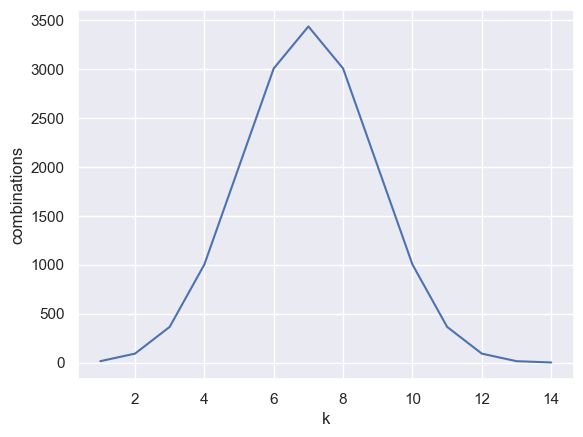

In [8]:
from scipy.special import factorial

n = 14
k = np.arange(1, n+1)
y = factorial(n) / (factorial(k)*factorial(n-k))

ax = sns.lineplot(x=k, y=y)
ax.set(xlabel='k', ylabel='combinations')

The plot above shows that there up to ~700,000 possible combinations of the predictors without repetition for some values of k when p = 22

The ISL authors provide comparison of the $R^2$ statistic for all combinations of 19 predictors. When p=19 the max number of combinations for any given subset is reduced by 10x, when p=10 the max combinations is reduced by ~2000x. 

My current machine maxed out its memory trying to compute all models for p=22. I'll try p=14 by picking 14 of the predictors for brevity. 



In [11]:
# Pick arbitrary subset of predictors to save compute/memory
X = hitters.loc[:, 'AtBat':'PutOuts']
y = hitters['Salary']

model_subsets = []
for k in range(1, 7):
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

Progess: k = 1, done
Progess: k = 2, done
Progess: k = 3, done
Progess: k = 4, done
Progess: k = 5, done
Progess: k = 6, done


Text(0.5, 1.0, 'BIC')

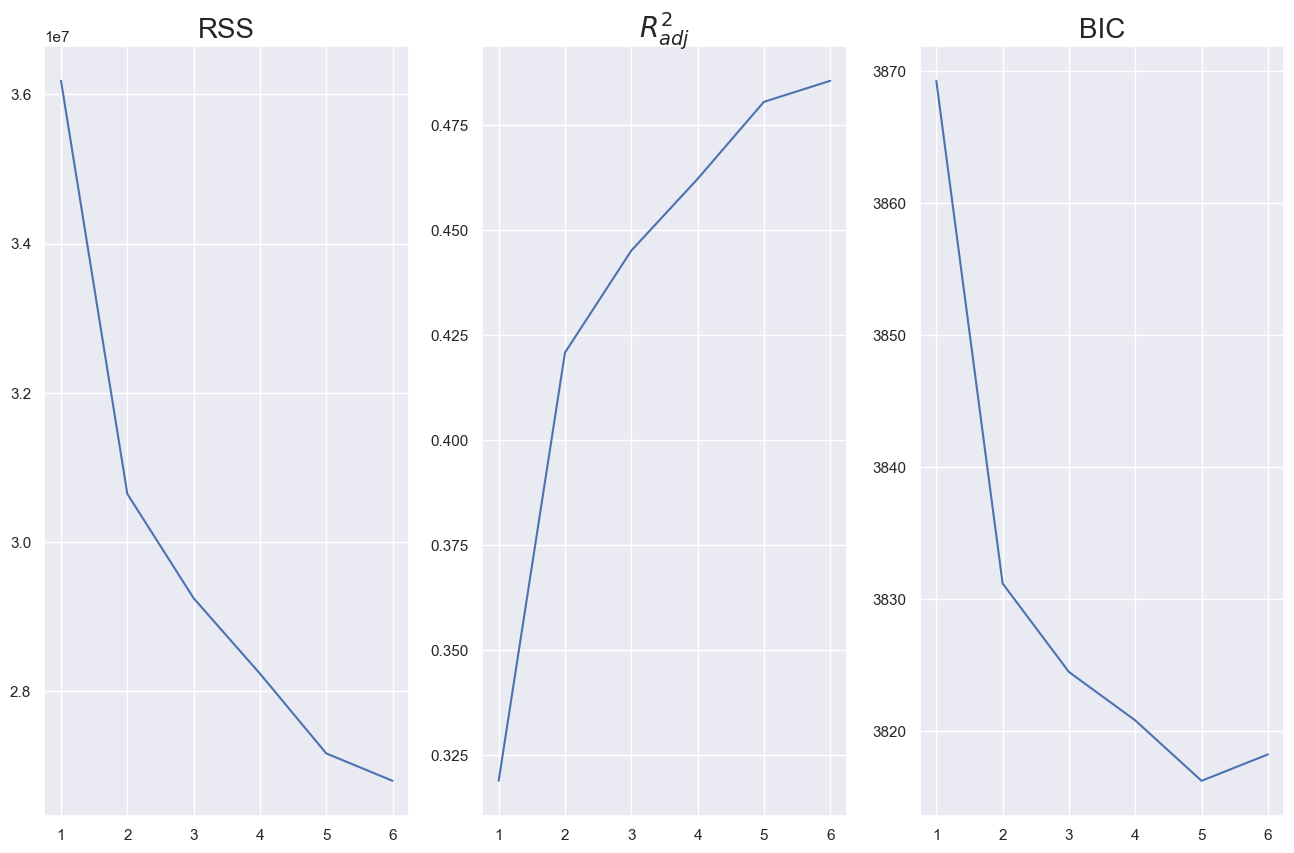

In [12]:
rss   = [min_rss(m)[1].ssr for m in model_subsets]
bic = [min_bic(m)[1].bic for m in model_subsets]
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]

k     = np.arange(1, len(rss)+1)

_, axes = plt.subplots(1,3,figsize=[16,10])


sns.lineplot(x=k, y=rss,ax = axes[0])
sns.lineplot(x=k, y=adjr2,ax = axes[1])
sns.lineplot(x=k, y=bic,ax = axes[2])
axes[0].set_title('RSS',fontsize=20)
axes[1].set_title('$R_{adj}^2$',fontsize=20)
axes[2].set_title('BIC',fontsize=20)

The stats above seem to confer that a model with around 8 predictors is best. But has each method chosen the same or similar models?

In [ ]:
best_subset_6 = list(min_rss(model_subsets[5])[1].params.index)[1:]
print(best_subset_6)

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']


In [ ]:
list(max_adjr2(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

In [ ]:
list(min_bic(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

All three statisticis yield the same model for the subset with 6 predictors. This is expected for RSS and R-squared stats because they are related.

### 6.5.2 Forward and Backward Stepwise Selection

In [ ]:
def forward_stepwise(X, y, results=[(0, [])]):
    # List predictors that havent's been used so far
    p_all    = list(X.columns)
    p_used   = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    # Job done, exit recursion
    if not p_unused:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds}).drop(0).reset_index()
    
    # Get rss score for each possible additional predictor
    r = []
    for p in p_unused:
        f     = 'Salary ~ {}'.format('+'.join([p]+p_used))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, [p]+p_used)]
    
    # Choose predictor which yields lowest rss
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    # Recursive call to self
    return forward_stepwise(X, y, new_results)

In [ ]:
def backward_stepwise(X, y, results=[]):
    # List predictors that havent's been used so far
    p_all    = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = 'Salary ~ {}'.format('+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        return backward_stepwise(X, y, [(model.ssr, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = 'Salary ~ {}'.format('+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, p_test)]
    
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    return backward_stepwise(X, y, new_results)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(hitters.loc[:, 'AtBat':'PutOuts'])
X_new = pd.DataFrame(X)
X_new.columns = hitters.loc[:, 'AtBat':'PutOuts'].columns
y = hitters['Salary']

forward_stepwise  = forward_stepwise(X_new, y)
print(forward_stepwise)
print('-'*30)
backward_stepwise = backward_stepwise(X_new, y)
print(backward_stepwise)

    index           rss                                         predictors
0       1  4.542829e+07                                          [PutOuts]
1       2  4.532160e+07                                   [Years, PutOuts]
2       3  4.522233e+07                             [CRBI, Years, PutOuts]
3       4  4.501844e+07                      [CRuns, CRBI, Years, PutOuts]
4       5  4.485676e+07              [CAtBat, CRuns, CRBI, Years, PutOuts]
5       6  4.477311e+07       [CHits, CAtBat, CRuns, CRBI, Years, PutOuts]
6       7  4.470303e+07  [AtBat, CHits, CAtBat, CRuns, CRBI, Years, Put...
7       8  4.426874e+07  [Runs, AtBat, CHits, CAtBat, CRuns, CRBI, Year...
8       9  4.416942e+07  [Walks, Runs, AtBat, CHits, CAtBat, CRuns, CRB...
9      10  4.411388e+07  [RBI, Walks, Runs, AtBat, CHits, CAtBat, CRuns...
10     11  4.409301e+07  [CHmRun, RBI, Walks, Runs, AtBat, CHits, CAtBa...
11     12  4.404634e+07  [HmRun, CHmRun, RBI, Walks, Runs, AtBat, CHits...
12     13  4.403416e+07  

In [ ]:
print('Best Subset Selection       : {}'.format(sorted(best_subset_6)))
print('Forward Stepwise Selection  : {}'.format(sorted(forward_stepwise.loc[5]['predictors'])))
print('Backward Stepwise Selection : {}'.format(sorted(backward_stepwise.loc[8]['predictors'])))

Best Subset Selection       : ['AtBat', 'CRBI', 'Division[T.W]', 'Hits', 'PutOuts', 'Walks']
Forward Stepwise Selection  : ['CAtBat', 'CHits', 'CRBI', 'CRuns', 'PutOuts', 'Years']
Backward Stepwise Selection : ['AtBat', 'CAtBat', 'CHits', 'CWalks', 'Runs', 'Years']


The above results show that Backward Stepwise Selection chooses the same 6 predictors as Best Subset Selection. Forward Stepwise Selection chooses all but one of the same predictors.

Backward Stepwise Selection therefore looks like the best approach as it makes the same optimal selection as best subset selection, but with significantly lower computational cost.

### 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [ ]:
def best_subset_rss(X, y):
    model_subsets = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k, X, y)
        model_subsets += [subset]
        print('Best subset selected: k = {}/{}, done'.format(k, len(X.columns)))
    # Get best rss score for each subset
    return [min_rss(m) for m in model_subsets]

def mse(y_hat, y):
    return np.sum(np.square(y_hat - y)) / y.size

In [ ]:
np.random.seed(1)
train = np.random.rand(len(hitters)) < 0.5

response   = 'Salary'

X_train = hitters[train].loc[:, 'AtBat':'PutOuts']
X_test  = hitters[~train].loc[:, 'AtBat':'PutOuts']
y_train = hitters[train][response]
y_test  = hitters[~train][response]

best_subsets = best_subset_rss(X_train, y_train)

Best subset selected: k = 1/14, done
Best subset selected: k = 2/14, done
Best subset selected: k = 3/14, done
Best subset selected: k = 4/14, done
Best subset selected: k = 5/14, done
Best subset selected: k = 6/14, done
Best subset selected: k = 7/14, done
Best subset selected: k = 8/14, done
Best subset selected: k = 9/14, done
Best subset selected: k = 10/14, done
Best subset selected: k = 11/14, done
Best subset selected: k = 12/14, done
Best subset selected: k = 13/14, done
Best subset selected: k = 14/14, done


,predictors,MSE
0,1,178139.358427
1,2,165215.400785
2,3,170773.977180
3,4,154020.720967
4,5,147281.971965
5,6,148387.589992
6,7,149105.946391
7,8,138481.274569
8,9,133463.544833
9,10,134906.763925


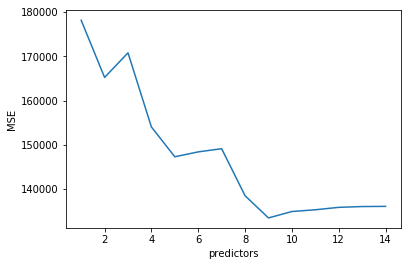

In [ ]:
# Using 50% hold out set
MSEs = []
for m in best_subsets:
    model = m[1]
    y_hat = model.predict(X_test)
    r     = mse(y_hat, y_test)
    MSEs += [r]

results = pd.DataFrame({'predictors': np.arange(1, 15), 'MSE': MSEs})
display(results)
sns.lineplot(x='predictors', y='MSE', data=results);

Above we performed best subset selection up to 14 predictors using the training set createad from a 50% hold-out set. We then use the test set to measure the MSE for the selected model in each subset of p predictors. 

We observe the lowest MSE for the model with 9 predictors.

In [ ]:
# Which 9 predictors did best subset selection choose based on the TRAINING set?
best_subsets[8][0]

'Salary ~ AtBat + Hits + HmRun + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts'

In [ ]:
# Which 9 predictors does best subset selection choose based on the FULL set?
best_subsets_full = best_subset_rss(hitters.loc[:, 'AtBat':'PutOuts'], hitters['Salary'])
best_subsets_full[8][0]

Best subset selected: k = 1/14, done
Best subset selected: k = 2/14, done
Best subset selected: k = 3/14, done
Best subset selected: k = 4/14, done
Best subset selected: k = 5/14, done
Best subset selected: k = 6/14, done
Best subset selected: k = 7/14, done
Best subset selected: k = 8/14, done
Best subset selected: k = 9/14, done
Best subset selected: k = 10/14, done
Best subset selected: k = 11/14, done
Best subset selected: k = 12/14, done
Best subset selected: k = 13/14, done
Best subset selected: k = 14/14, done


'Salary ~ AtBat + Hits + Runs + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts'

This time the same model is selected using the full dataset, as is selected using just the training set. This won't always be the case however, so the ISL authors reccomend taking the model that best subset selection chooses using the full dataset.

**Revision note:** My understanind of what the authors seem to be suggesting is:

- fit all possible models on training set
- choose best model in each subset by RSS
- use test MSE to choose best subset, e.g optimal number of predictors *p*
- fit all possible models with optimal value of p predictors on *full* dataset
- choose best model by RSS

This seems odd to me because the model finaly chosen has not been verified on the test set. If the actual predictors are to be chosen on the full set, why not pass this model through validation? Note that this does not mean the model fitted on full dataset is then used in test:

- fit all possible models on full dataset
- choose best combination of predictors in each subset by RSS
- use above choices to fit models on training set
- use test MSE to choose best subset
- model with lowest MSE is chosen

This approach also seems to simplify use of best subset selection with cross-validation:

- fit all possible models on full dataset
- choose best combination of predictors in each subset by RSS
- choose from above predictor subsets using cross validation

In [ ]:
def cross_val(formula, X, y, k):
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = smf.ols(formula=formula, data=pd.concat([X_train, y_train], axis=1)).fit()
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return (MSEs, formula)
    

In [13]:
# Get best subsets of predictors for full dataset
X = hitters.loc[:, 'AtBat':'PutOuts']
y = hitters['Salary']

best_subsets_full = best_subset_rss(X, y)

NameError: name 'best_subset_rss' is not defined

In [ ]:
# Perform cross validation for each subset of predictors
results = [cross_val(sub[0], X, y, 10) for sub in best_subsets_full]
results_a_df = pd.DataFrame({'predictors': list(np.arange(1, 15)),
                           'MSE_mean': [np.mean(i[0]) for i in results],
                           'MSE_folds': [i[0] for i in results],
                           'Model': [i[1] for i in results]})
display(results_a_df)
sns.lineplot(x='predictors', y='MSE_mean', data=results_a_df);

NameError: name 'best_subsets_full' is not defined

In [ ]:
best_subset_choice = results_a_df[results_a_df['MSE_mean'] == results_a_df['MSE_mean'].min()]
display(best_subset_choice)

best_subset_choice['Model'].iloc[0]

,predictors,MSE_mean,MSE_folds,Model
7,8,109522.011671,"[86417.0694422955, 30716.914843531533, 165276....",Salary ~ AtBat + Hits + Walks + CAtBat + CRuns...


'Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts'

We see that 10-fold cross validation selects an 8 variable model. The estimated test MSE is 109,522.

**Revision note:** The ISL authors (p.250) land on an 11 variable model with a higher average MSE of 125,154. Why is this?



### Can we get a better model by Backwards Stepwise on all features?

,rss,predictors,predictor_count
0,2.420070e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",1
1,2.420070e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",2
2,2.420070e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",3
3,2.420070e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",4
4,2.420184e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, Years, ...",5
5,2.420945e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...",6
6,2.421938e+07,"[AtBat, Hits, HmRun, Runs, RBI, Walks, CAtBat,...",7
7,2.423518e+07,"[AtBat, Hits, HmRun, Runs, Walks, CAtBat, CHit...",8
8,2.424866e+07,"[AtBat, Hits, HmRun, Runs, Walks, CAtBat, CRun...",9
9,2.428915e+07,"[AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI...",10


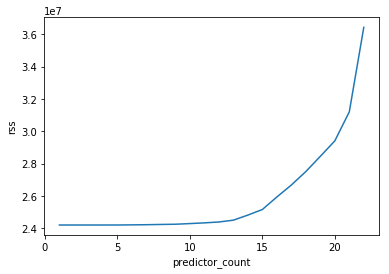

In [ ]:
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

backward_stepwise_subsets = backward_stepwise(X, y)
backward_stepwise_subsets['predictor_count'] = np.arange(1, 23)
display(backward_stepwise_subsets)

sns.lineplot(x='predictor_count', y='rss', data=backward_stepwise_subsets);

,predictors,MSE_mean,MSE_folds,Model
0,1,116599.013674,"[109666.77700982487, 37953.39175638854, 156572...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
1,2,116599.013674,"[109666.7770098258, 37953.39175638837, 156572....",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
2,3,116599.013674,"[109666.77700982455, 37953.39175638841, 156572...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
3,4,116599.013674,"[109666.77700982522, 37953.39175638851, 156572...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
4,5,114963.338465,"[108403.40077544513, 36671.65478063551, 156237...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
5,6,113635.830694,"[103548.9789642152, 34980.6193407436, 156343.0...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
6,7,112921.381689,"[103109.24440272473, 35032.07078000676, 155352...",Salary ~ AtBat + Hits + HmRun + Runs + RBI + W...
7,8,111081.510651,"[103134.03455700394, 35026.977780520996, 15560...",Salary ~ AtBat + Hits + HmRun + Runs + Walks +...
8,9,110333.364753,"[98326.25400454745, 35152.30612149243, 155838....",Salary ~ AtBat + Hits + HmRun + Runs + Walks +...
9,10,109979.410931,"[95894.57297758816, 35826.8320322134, 155992.7...",Salary ~ AtBat + Hits + Runs + Walks + CAtBat ...


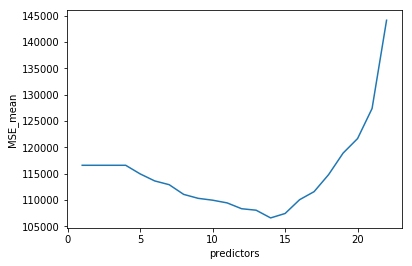

In [ ]:
# Perform cross validation for each subset of predictors
results = []
for preds in backward_stepwise_subsets['predictors']:
    f = 'Salary ~ {}'.format(' + '.join(preds))
    results += [cross_val(f, X, y, 10)]

results_b_df = pd.DataFrame({'predictors': list(np.arange(1, len(results)+1)),
                           'MSE_mean': [np.mean(i[0]) for i in results],
                           'MSE_folds': [i[0] for i in results],
                           'Model': [i[1] for i in results]})
display(results_b_df)
sns.lineplot(x='predictors', y='MSE_mean', data=results_b_df);

In [ ]:
display(HTML('</br><h4>Best Subset Selection from 14 predictors, with 10-fold Cross Validation</h4>'))
best_subset_choice = results_a_df[results_a_df['MSE_mean'] == results_a_df['MSE_mean'].min()]
display(best_subset_choice)
print(best_subset_choice['Model'].iloc[0])

display(HTML('</br><h4>Backward Stepwise Selection from all 22 predictors, with 10-fold Cross Validation</h4>'))
backward_select_choice = results_b_df[results_b_df['MSE_mean'] == results_b_df['MSE_mean'].min()]
display(backward_select_choice)
print(backward_select_choice['Model'].iloc[0])

,predictors,MSE_mean,MSE_folds,Model
7,8,109522.011671,"[86417.0694422955, 30716.914843531533, 165276....",Salary ~ AtBat + Hits + Walks + CAtBat + CRuns...


Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts


,predictors,MSE_mean,MSE_folds,Model
13,14,106618.881999,"[94639.91163274275, 40255.25372375629, 160138....",Salary ~ AtBat + Hits + Walks + CAtBat + CRuns...


Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Division_W


Abov we used backward stepwise selection to make it computationally feasible (on my laptop) to select from all 22 features. 

We see that 10-fold cross validation selects a 14 variable model. The estimated test MSE is 106,618. This represents an improvement on the lowest esitmate MSe achived for best subset selection from 14 features which was 109,522.

Note that Backward Stepwise Selection found the same model, but gained an improved MSE by adding one additional predictor, 'Division_W', which wasn't available to best subset selection due to the constraints of the available compute. 

## Lab 2: Ridge Regression and the Lasso

### 6.6.1 Ridge Regression

Let's perform ridge regression with 10-fold cross-validation to produce results comparable to those obtained for model selection approaches aboce.

In [ ]:
def ridge_cv(X, y, λ, k):
    """Perform ridge regresion with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = Ridge(alpha=λ, fit_intercept=False, solver='cholesky').fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

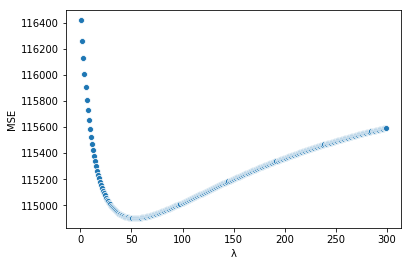

In [ ]:
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

#lambdas = np.arange(0, 0.08, 0.0005)
lambdas = np.arange(1, 300, 1)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(ridge_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [ ]:
min(zip(MSEs, lambdas))

(114903.19824046272, 53)

Here we use 10-fold cross-validation to find the optimal value for lambda. The lowest MSE score achieved is 114,903 when λ=53.

**Revision note:** This result is worst than our results for backward stepwise selection (106,618) and best subset (109,522), and not as good as that reported by ISL authors (96,016) on p.254.

A very small improvement was observed by setting fit_intercept and normalize to True - in which case the optimal values of lambda became significantly smaller.

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 11 Text xticklabel objects>)

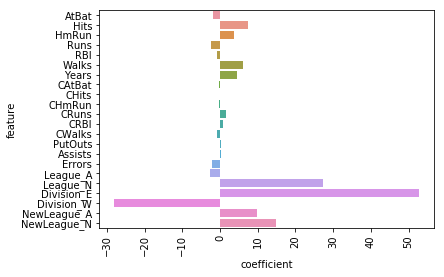

In [ ]:
# What coefficients does ridge regression choose for the optimal lambda value?
model = Ridge(alpha=53, fit_intercept=False, solver='cholesky').fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)

### 6.6.2 The Lasso

In [ ]:
def lasso_cv(X, y, λ, k):
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, copy_X=True, fit_intercept=False, max_iter=10000,
                                   normalize=False, positive=False, precompute=False, random_state=None,
                                   selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

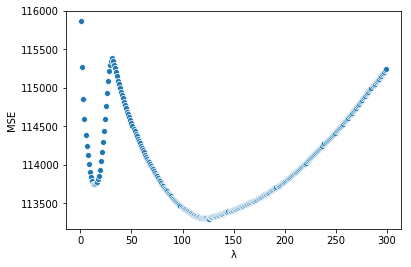

In [ ]:
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

lambdas = np.arange(1, 300, 1)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [ ]:
min(zip(MSEs, lambdas))

(113299.42601088567, 126)

Here we use 10-fold cross-validation to find the optimal lambda value for the lasso. The lowest MSE score achieved is 113,299 when λ=126.

**Revision note:** This result is marginally better than the result for ridge regression (114,903) which is suprising because the ISL authors observed the opposite.

(array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 9 Text xticklabel objects>)

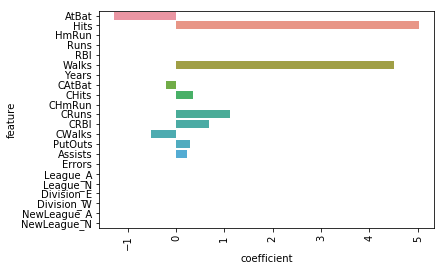

In [ ]:
# What coefficients does the lasso choose for the optimal lambda value?
model = linear_model.Lasso(alpha=126, copy_X=True, fit_intercept=False, max_iter=10000,
                           normalize=False, positive=False, precompute=False, random_state=None,
                           selection='cyclic', tol=0.0001, warm_start=False).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)

Lasso makes quite different feature choices to ridge regression, completeley ignoring the dummy variables.

In [ ]:
print('Salary ~ {}'.format(' + '.join(X.columns[model.coef_ != 0])))
print('MSE: {:01.0f}'.format(min(MSEs)))

print(backward_select_choice['Model'].iloc[0])
print('MSE: {:01.0f}'.format(backward_select_choice['MSE_mean'].iloc[0]))

Salary ~ AtBat + Hits + Walks + CAtBat + CHits + CRuns + CRBI + CWalks + PutOuts + Assists
MSE: 113299


Salary ~ AtBat + Hits + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts + Division_W
MSE: 106619


The results here suggesat that backward stepwise finds as simpler model tha toutperforms lasso and ridge regression. 

**Revision note:** This is contrary to ISL authors results so needs checking.

## Lab 3: PCR and PLS Regression

### 6.7.1 Principle Components Regression

In [ ]:
from sklearn.decomposition import *
from sklearn.cross_decomposition import *

In [ ]:
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

#### PCA

What percentage of total variance in our dataset is ecplained by succesive accumulation of principal components?

Get all principal components of the predictors in X, using principal component analysis (PCA)

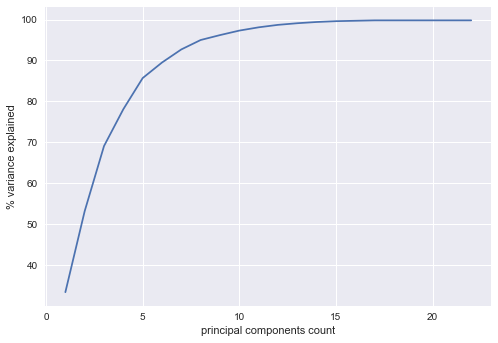

In [ ]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

variance_explained   = np.cumsum(np.around(pca.explained_variance_ratio_ *100, decimals=1))
principal_components = np.arange(1, len(variance_explained)+1)

sns.lineplot(x='principal components count', y='% variance explained', 
             data=pd.DataFrame({'principal components count': principal_components, 
                                '% variance explained': variance_explained}));

In [ ]:
X_reduced = pca.fit_transform(scale(X))
X_reduced.shape

(263, 22)

#### PCR 

How does linear regression perform when these principle components are used as predictors?

In [ ]:
def pcr_cv(seed, cv_folds):
    # Load data
    X = hitters.drop('Salary', axis=1)
    y = hitters['Salary']
    
    pca = PCA()
    X_reduced = pca.fit_transform(scale(X))
    
    M = X_reduced.shape[1]
    MSEs = []
    for m in range(M):
        model = LinearRegression()
        cv    = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        cv10  = cross_val_score(model, X_reduced[:, 0:m+1], y, cv=cv, scoring='neg_mean_squared_error')
        MSEs += [np.mean(np.abs(cv10))]
        
    ax = sns.lineplot(x='principal components count', y='MSE', 
                 data=pd.DataFrame({'principal components count': principal_components, 
                                    'MSE': MSEs}));
    ax.axes.set(ylim=(100000, 140000)

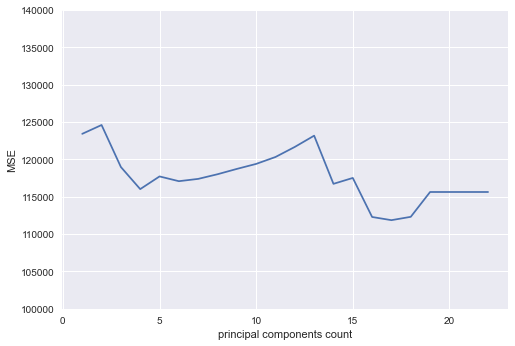

<function __main__.pcr_cv(seed, cv_folds)>

In [ ]:
from ipywidgets import *

interact(pcr_cv, 
         seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
         cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10))

The ISL authors report a minimum MSE when the number of principle componenents M = 16.  

Above I've implemented the same with interactive sliders to control the random seed used to shuffle observations before splitting into cross validation folds, and a seperate control for number of cross validation folds k. 

Interacting with the seed slider we see that there is some significant variability in the results. With 10 folds, most seed values would lead us to conclude the between 16-18 principal components are optimal, but there are some seed values – such as 8 – that suggest 6-7 components is in fact optimal. This is a significantly different conclusion!

The results seem to have higher variance when cv_folds is lower, with variance decreasing as the number of folds increases.

**Revision note:** The above point seems counter to what we learned in ch.5, e.g. we expect LOOCV to exhibit highest variance and lowest bias.

In [ ]:
def pcr_holdout(seed):
    # With 50% holdout set
    np.random.seed(seed)
    train = np.random.rand(len(hitters)) < 0.5
    
    pca = PCA()
    X_train = pca.fit_transform(scale(hitters.drop('Salary', axis=1)[train]))
    y_train = hitters['Salary'][train]
    X_test  = pca.fit_transform(scale(hitters.drop('Salary', axis=1)[~train]))
    y_test  = hitters['Salary'][~train]
    
    M = X_train.shape[1]
    
    MSEs = []
    for m in range(M):
        model = LinearRegression().fit(X_train[:, 0:m+1], y_train)
        y_hat = model.predict(X_test[:, 0:m+1])
        MSEs += [mse(y_hat, y_test)]
    
    
    ax = sns.lineplot(x='principal components count', y='MSE', 
                      data=pd.DataFrame({'principal components count': principal_components, 
                                         'MSE': MSEs}))
    ax.axes.set(ylim=(50000, 200000)

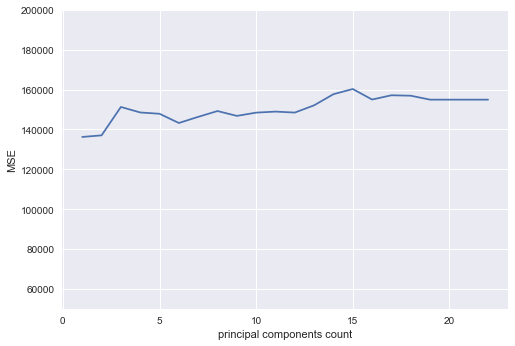

<function __main__.pcr_holdout(seed)>

In [ ]:
interact(pcr_holdout, seed=widgets.IntSlider(min=1, max=50, step=1, value=10))

The ISL authors report an 50% hold-out MSE of 96556 when M=7. This seems low in comparison to the initial result we observe above, with a random seed of 10 we see min MSE of about 140000 with M=1. 

Interacting with the seed slider we can find results comparable to those reported by the authors – for example when the seed = 3 a minimum MSE of about 85000 is observed for M=7. 

This outlines the importance of understanding the variance in results due to training/test set sampling, before making any comparisons.

For example previously I concluded that backward stepwise selection yielded the lowest MSE, whereas the ISL found ridge regression most effective. It seems that either of these observations could be correct, or both wrong, given the unquantified variance in results due to cross validation sampling.

Possible mitigations:

1. Ensure that identical observation samples are used in each fold when comparing techniques. This approach is limited because a certain approach might just happen to perform particularly well with the chosen samples.
2. Measure the probabilistic distribution of results for each approach and compare. This allows you to quantify the confidence of any conclusions.

**Revision notes:** discuss

#### PLS

In [ ]:
def pls_cv(seed, cv_folds):
    X = hitters.drop('Salary', axis=1)
    y = hitters['Salary']
    
    M = X.shape[1]
    MSEs = []
    for m in range(M):
        cv      = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        results = cross_val_score(PLSRegression(n_components=m+1, scale=True, max_iter=10), 
                                  X, y, cv=cv, scoring='neg_mean_squared_error')
        MSEs   += [np.mean(np.abs(results))]
        
    ax = sns.lineplot(x='principal components count', y='MSE', 
                 data=pd.DataFrame({'principal components count': principal_components, 
                                    'MSE': MSEs}))
    ax.axes.set(ylim=(100000, 140000)

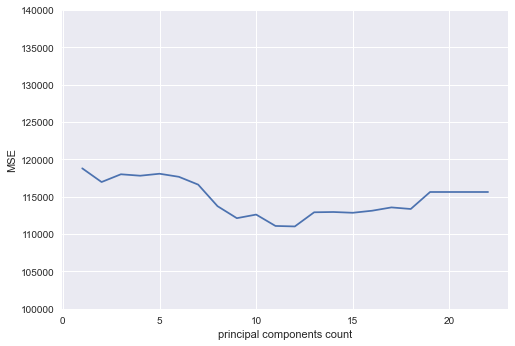

<function __main__.pls_cv(seed, cv_folds)>

In [ ]:
interact(pls_cv, 
         seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
         cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10))

PLS seems to perform similarly to PCR with fewer predictors, although we cannot be conclusive due to variance in our cv.

# Conceptual

In [ ]:
import numpy as np

## 1. We perform best subset, forward stepwise, and backward stepwise selection on a single data set. For each approach, we obtain p + 1 models, containing 0, 1, 2, . . . , p predictors. Explain your answers:

### (a) Which of the three models with k predictors has the smallest training RSS?

`Best subset selection` will exhibit the smallest training RSS because all possible combinations of predictors are considered for a given k. It is possible that the most effective model is also found by forward stepwise or backward stepwise, but not possible that they will find a model more effective than best subset, as the former consider a subset of the models considered by best subset selection.

### (b) Which of the three models with k predictors has the smallest test RSS?

`Best subset selection` will certainly yield the smallest test rss, this model might also be discovered by forward stepwise or backward stepwise but this is not certain.

### (c) True or False:

- i. The predictors in the k-variable model identified by forward stepwise are a subset of the predictors in the (k+1)-variable model identified by forward stepwise selection.

    - True

- ii. The predictors in the k-variable model identified by backward stepwise are a subset of the predictors in the (k + 1)- variable model identified by backward stepwise selection.

    - True

- iii. The predictors in the k-variable model identified by backward stepwise are a subset of the predictors in the (k + 1)- variable model identified by forward stepwise selection.

    - False

- iv. The predictors in the k-variable model identified by forward stepwise are a subset of the predictors in the (k+1)-variable model identified by backward stepwise selection.

    - False

- v. The predictors in the k-variable model identified by best subset are a subset of the predictors in the (k + 1)-variable model identified by best subset selection.

    - False

## 2. For parts (a) through (c), indicate which of i. through iv. is correct. Justify your answer.

### (a) The lasso, relative to least squares, is:

- i. More flexible and hence will give improved prediction accuracy when its increase in bias is less than its decrease in variance.

    - Incorrect. Least squares uses all features, whereas lasso wil either use all features or set coefficients to zero for some features – so lasso is either equivalent to least squares or less flexible.

- ii. More flexible and hence will give improved prediction accuracy when its increase in variance is less than its decrease in bias.

    - Incorrect

- iii. Less flexible and hence will give improved prediction accuracy when its increase in bias is less than its decrease in variance.

    - Correct. As λ is increased the variance of the model will decrease quickly for a small increase in bias resulting in improved test MSE. At some point the bias will start to increase dramatically outweighing any benefits from further reduction in variance, at the expense of test MSE.

- iv. Less flexible and hence will give improved prediction accuracy when its increase in variance is less than its decrease in bias.

    - Incorrect

### (b) Repeat (a) for ridge regression relative to least squares.

- i. More flexible and hence will give improved prediction accuracy when its increase in bias is less than its decrease in variance.

    - Incorrect. Same as for lasso

- ii. More flexible and hence will give improved prediction accuracy when its increase in variance is less than its decrease in bias.

    - Incorrect. Same as for lasso

- iii. Less flexible and hence will give improved prediction accuracy when its increase in bias is less than its decrease in variance.

    - Correct. Same as for lasso

- iv. Less flexible and hence will give improved prediction accuracy when its increase in variance is less than its decrease in bias.
    - Incorrect. Same as for lasso

### (c) Repeat (a) for non-linear methods relative to least squares.

- i. More flexible and hence will give improved prediction accuracy when its increase in bias is less than its decrease in variance.

    - Incorrect

- ii. More flexible and hence will give improved prediction accuracy when its increase in variance is less than its decrease in bias.

    - Correct. If the data contains non-linear relationships then the reduction in bias will outweigh the increase in variance as the model better fitst the data. At some point the model will become too flexible and will start to overfit the data at which point increased variance will begin to outwiegh any further reduction in bias.

- iii. Less flexible and hence will give improved prediction accuracy when its increase in bias is less than its decrease in variance.

    - Incorrect

- iv. Less flexible and hence will give improved prediction accuracy when its increase in variance is less than its decrease in bias.


    - Incorrect


## 3. Suppose we estimate the regression coefficients in a linear regression model by minimizing for a particular value of s. For parts (a) through (e), indicate which of i. through v. is correct. Justify your answer.

### (a) As we increase s from 0, the training RSS will:

- iv. Steadily decrease.

As we increase s we increase the models flexibility, in the training setting this will lead to overfitting and a monotonic decrease in the RSS error.

### (b) Repeat (a) for test RSS.

- ii. Decrease initially, and then eventually start increasing in a U shape.

The increased flexibility of our model improves our models performance in the test setting up until the point where our model starts to overfit the data.

### (c) Repeat (a) for variance.

- iii. Steadily increase.

Reduced constraint on sum of coefficients means monotonic increase in flexibility – increase variance

### (d) Repeat (a) for (squared) bias.

- iv. Steadily decrease.

Reduced constraint on sum of coefficients means monotonic decrease in bias.

### (e) Repeat (a) for the irreducible error.

- v. Remain constant.

The irreducible error represents the inherent noise in our data, because this noise is random it contains no useful information and remains constant regardless of the models flexibility.

## 4. Suppose we estimate the regression coefficients in a linear regression model by minimizing for a particular value of λ. For parts (a) through (e), indicate which of i. through v. is correct. Justify your answer.

### (a) As we increase λ from 0, the training RSS will:

- iii. Steadily increase.

As lambda increases a heavier penalty is placed on a higher total value of coefficients so the model becomes less flexible and so is less able to fite variability in the training data.

### (b) Repeat (a) for test RSS.

- ii. Decrease initially, and then eventually start increasing in a U shape.

As lambda increases the models bias is increased reducing any overfitting of the training data and so improving the test RSS accuracy. At some point the bias will increase to the point that our model is less able to represent true relationships in the data.



### (c) Repeat (a) for variance.

- iv. Steadily decrease.

As lambas increases a higher penalty is placed on model flexibility and so variance decreases.


### (d) Repeat (a) for (squared) bias.

- iii. Steadily increase.

As lambda increases coefficient estimates are reduced and so bias increases.

### (e) Repeat (a) for the irreducible error.

- v. Remain constant.

Irreducible error is not effected by the model.

## 5. It is well-known that ridge regression tends to give similar coefficient values to correlated variables, whereas the lasso may give quite different coefficient values to correlated variables. We will now explore this property in a very simple setting.

## Suppose that n = 2, p = 2, x11 = x12, x21 = x22. Furthermore, suppose that y1+y2 =0 and x11+x21 =0 and x12+x22 =0, so that the estimate for the intercept in a least squares, ridge regression, or lasso model is zero: βˆ0 = 0.

### (a) Write out the ridge regression optimization problem in this setting.

![6_5.jpg](./images/6_5.jpg)

### (b) Argue that in this setting, the ridge coefficient estimates satisfy βˆ 1 = βˆ 2 .

![6_5bi.jpg](./images/6_5bi.jpg)
![6_5bii.jpg](./images/6_5bii.jpg)

### (c) Write out the lasso optimization problem in this setting.

### (d) Argue that in this setting, the lasso coefficients βˆ1 and βˆ2 are not unique—in other words, there are many possible solutions to the optimization problem in (c). Describe these solutions.

![6_5cd.jpg](./images/6_5cd.jpg)

## 6. We will now explore (6.12) and (6.13) further.

### (a) Consider (6.12) with p = 1. For some choice of y1 and λ > 0, plot (6.12) as a function of β1. Your plot should confirm that (6.12) is solved by (6.14).

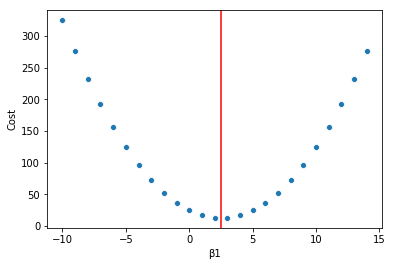

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def rr(y1, β1, λ):
    return np.power(y1 - β1, 2) + λ*(β1**2)

y1 = 5
λ  = 1
β = list(range(-10, 15))
results = [rr(y1, β1, λ) for β1 in β]
βR = y1/(1+λ)

ax = sns.scatterplot(x=β, y=results)
ax.axvline(x=βR, color='r')
ax.set(xlabel='β1')
ax.set(ylabel='Cost');


### (b) Consider (6.13) with p = 1. For some choice of y1 and λ > 0, plot (6.13) as a function of β1. Your plot should confirm that (6.13) is solved by (6.15).

np.absolute(y1) <= λ/2


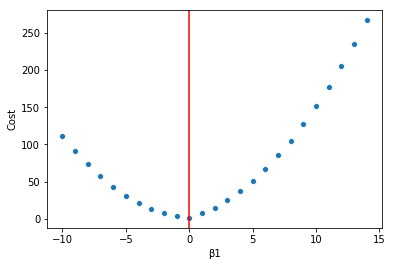

In [ ]:
def lasso(y1, β1, λ):
    return np.power(y1 - β1, 2) + λ*(np.absolute(β1))

y1 = -1
λ  = 3
β = list(range(-10, 15))
results = [lasso(y1, β1, λ) for β1 in β]

if y1 > λ/2:
    print('y1 > λ/2')
    βL = y1 - λ/2
if y1 < -λ/2:
    print('y1 < -λ/2')
    βL = y1 + λ/2
if np.absolute(y1) <= λ/2:
    print('np.absolute(y1) <= λ/2')
    βL = 0

ax = sns.scatterplot(x=β, y=results)
ax.axvline(x=βL, color='r')
ax.set(xlabel='β1')
ax.set(ylabel='Cost');

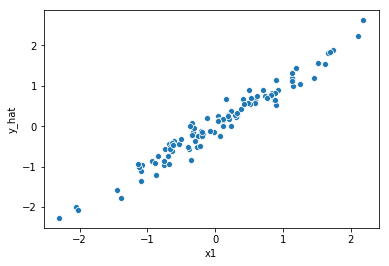

In [ ]:
np.random.seed(1)
x1 = np.random.normal(0, 1, 100)
y_hat = x1 + np.random.normal(0, 1, 100)*0.2

ax = sns.scatterplot(x=x1, y=y_hat)
ax.set(xlabel='x1')
ax.set(ylabel='y_hat');

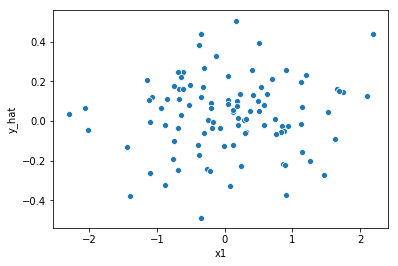

In [ ]:
np.random.seed(1)
x1 = np.random.normal(0, 1, 100)
y_hat = np.random.normal(0, 1, 100)*0.2

sns.scatterplot(x=x1, y=y_hat)
ax.set(xlabel='x1')
ax.set(ylabel='y_hat');